<a href="https://colab.research.google.com/github/angelpati/Drivers-Drowsiness-Detection-/blob/main/Untitled33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving WIN_20250526_23_00_09_Pro.mp4 to WIN_20250526_23_00_09_Pro (1).mp4


In [3]:
!pip install opencv-python dlib imutils scipy


In [4]:
from google.colab import files
uploaded = files.upload()

Saving shape_predictor_68_face_landmarks (1).dat to shape_predictor_68_face_landmarks (1).dat


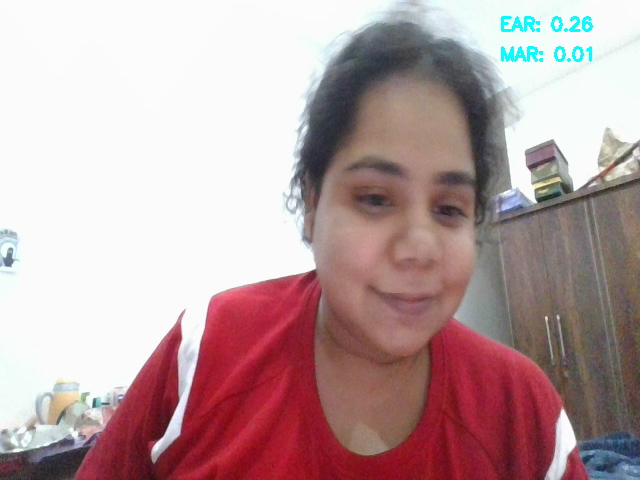

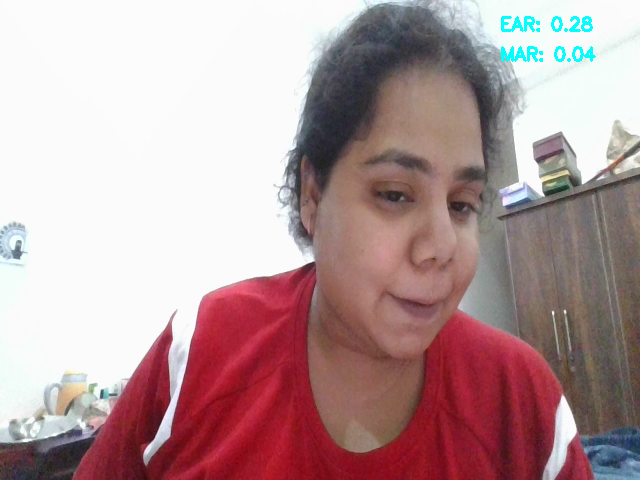

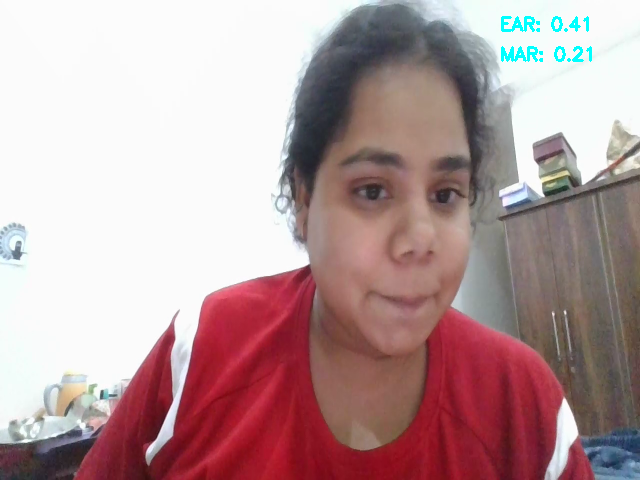

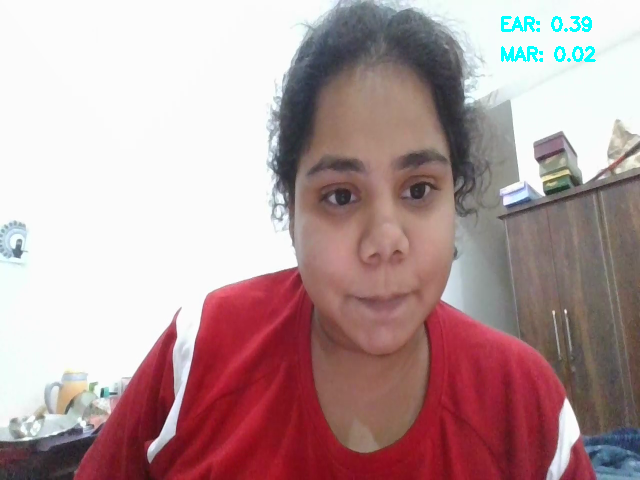

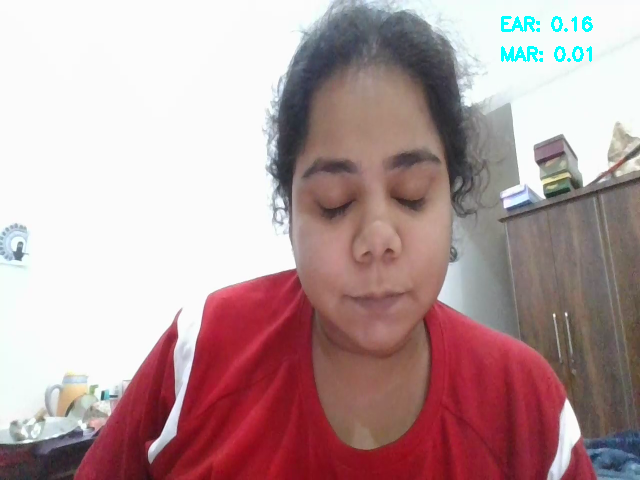

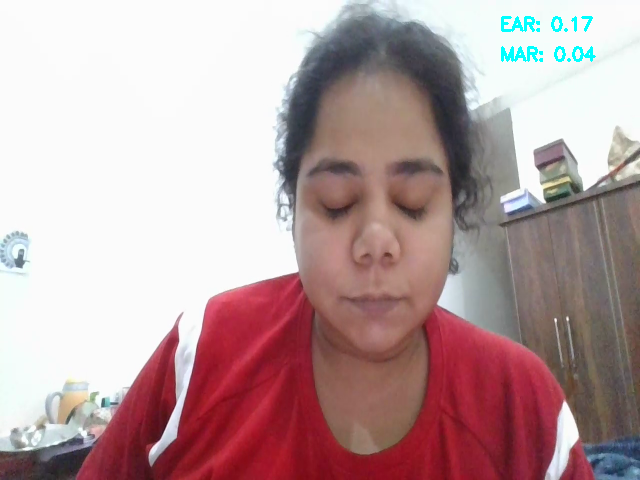

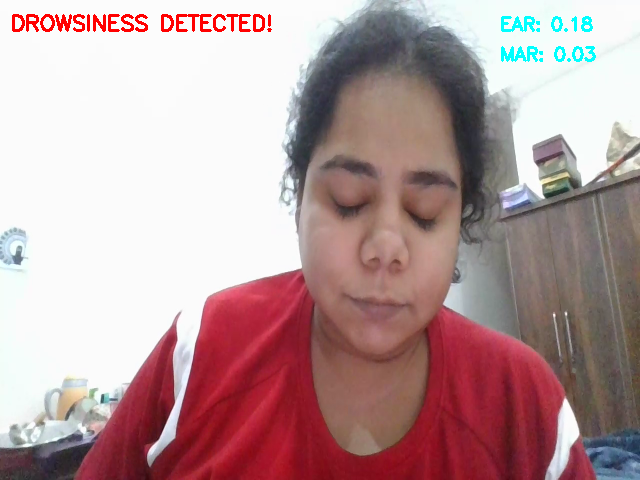

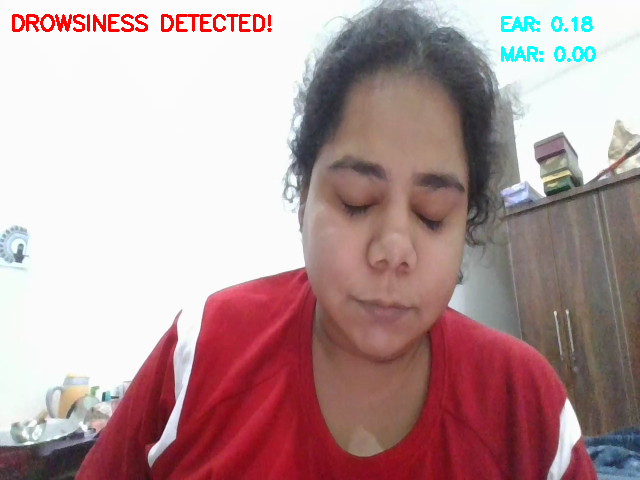

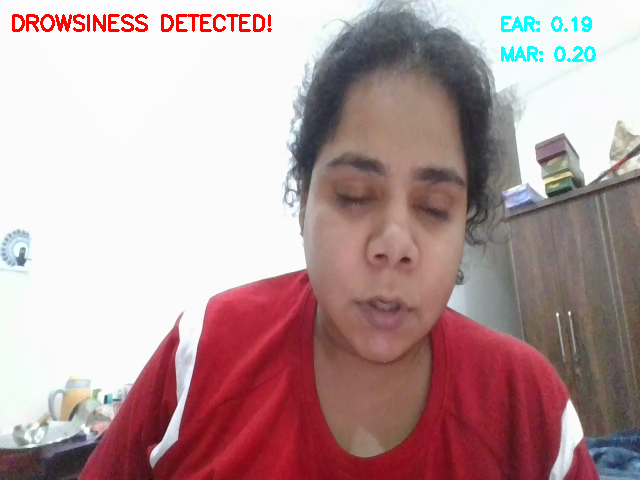

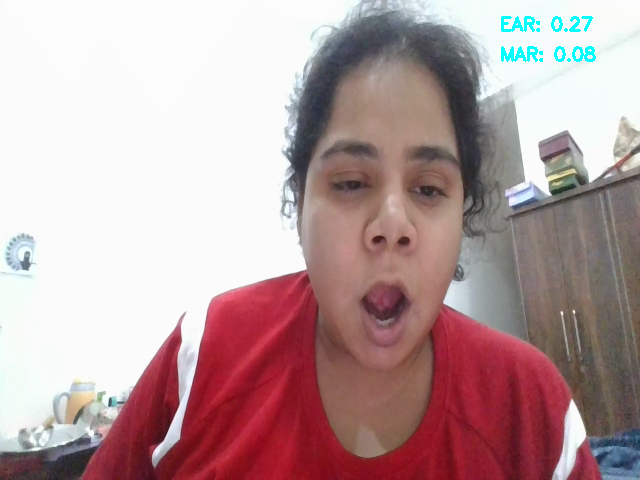

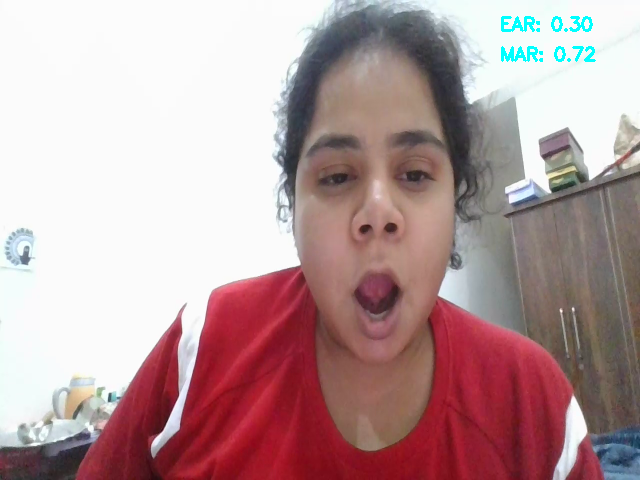

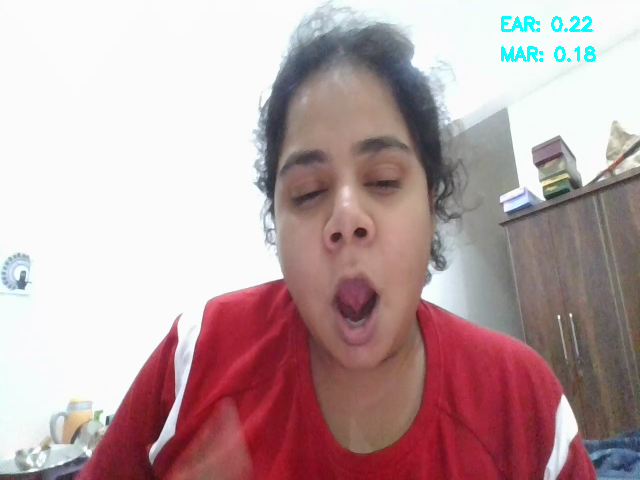

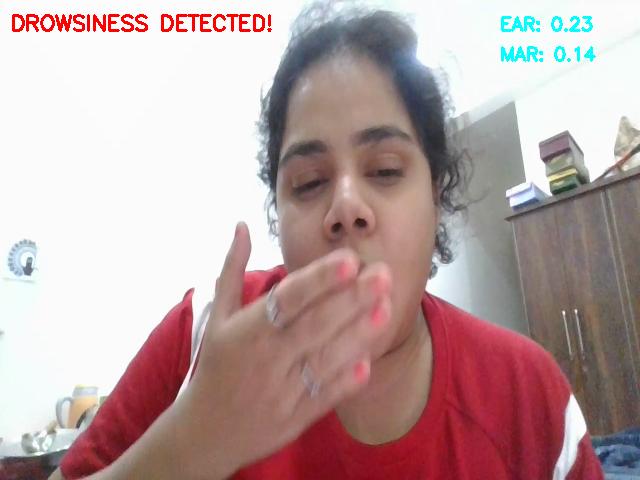

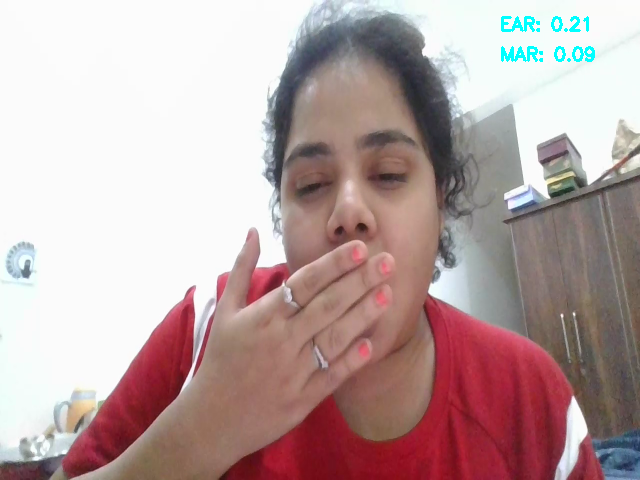

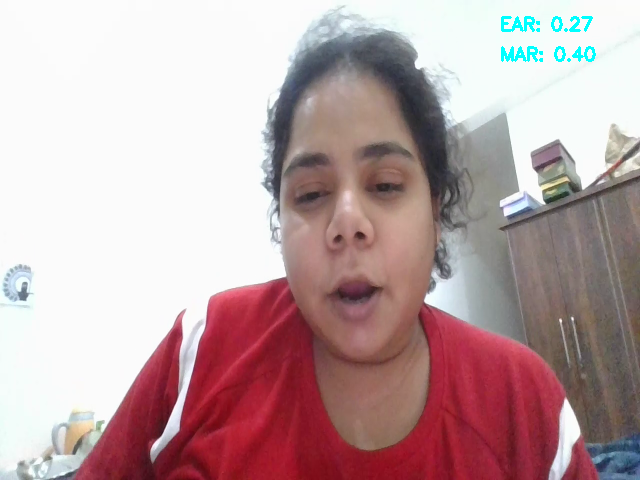

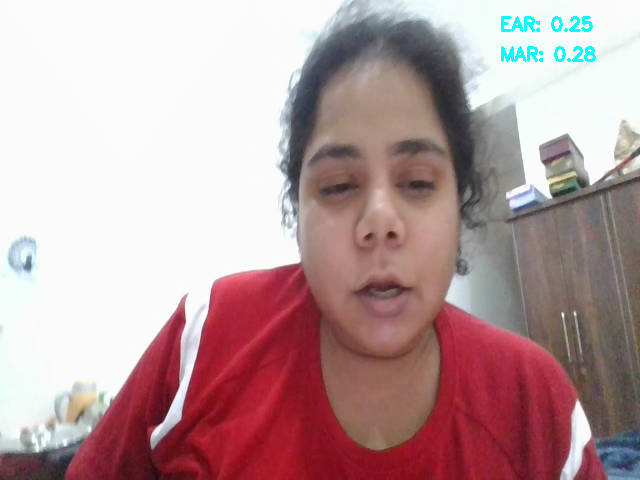

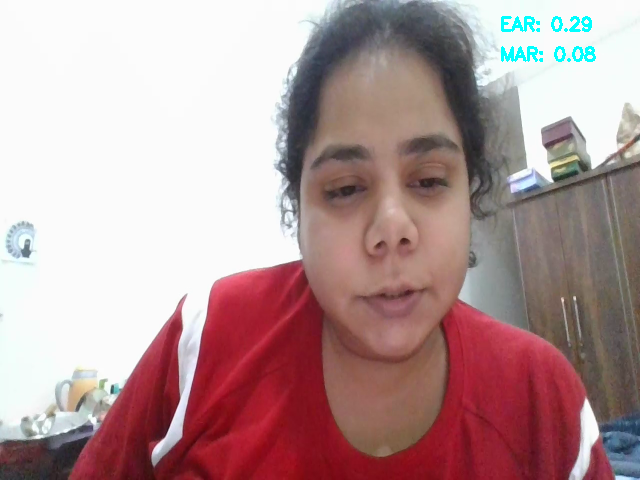

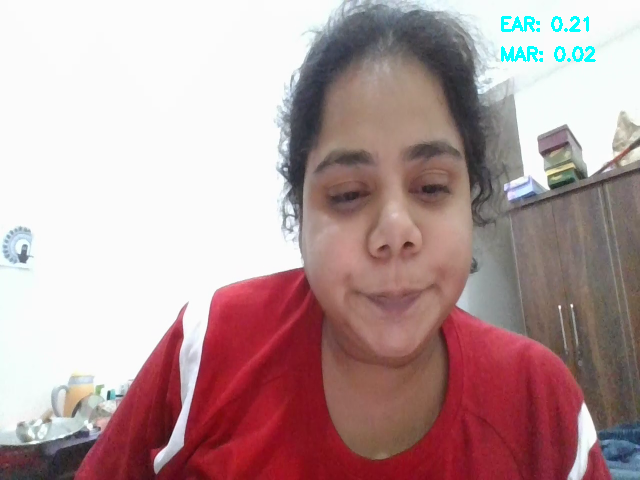

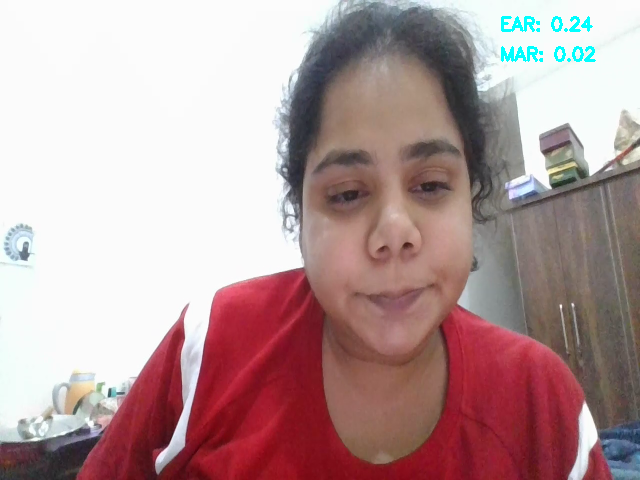

In [6]:
import cv2
import dlib
import time
import numpy as np
from scipy.spatial import distance
from imutils import face_utils
from google.colab.patches import cv2_imshow

# Constants
EAR_THRESHOLD = 0.25
EAR_CONSEC_FRAMES = 20
MAR_THRESHOLD = 0.75

COUNTER = 0
YAWN_COUNT = 0

# Load Dlib models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks (1).dat")

# Indices
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]

# EAR and MAR Functions
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[13], mouth[19])
    B = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[15], mouth[17])
    D = distance.euclidean(mouth[12], mouth[16])
    return (A + B + C) / (3.0 * D)

# 🎥 Load uploaded video
video_path = 'WIN_20250526_23_00_09_Pro.mp4'  # Change this to match the uploaded file
cap = cv2.VideoCapture(video_path)

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (640, 480))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)

    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        mouth = shape[mStart:mEnd]

        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        ear = (leftEAR + rightEAR) / 2.0
        mar = mouth_aspect_ratio(mouth)

        if ear < EAR_THRESHOLD:
            COUNTER += 1
            if COUNTER >= EAR_CONSEC_FRAMES:
                cv2.putText(frame, "DROWSINESS DETECTED!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        else:
            COUNTER = 0

        if mar > MAR_THRESHOLD:
            YAWN_COUNT += 1
            cv2.putText(frame, "YAWNING DETECTED!", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        # Draw values
        cv2.putText(frame, f"EAR: {ear:.2f}", (500, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
        cv2.putText(frame, f"MAR: {mar:.2f}", (500, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Show every 10th frame to avoid flooding output
    if frame_count % 10 == 0:
        cv2_imshow(frame)
    frame_count += 1

cap.release()
